In [1]:
import deeptrack as dt
from deeptrack.aberrations import Astigmatism

class beads:
    
    def __init__(self,
                xy_position = (5, 25), # pixel
                intensity = 1.0e4,
                z_position = -4.5,  # pixel
                wavelength = 600, # nm
                NA = 0.9,
                magnification = 1,
                resolution = 0.1, # um
                image_size = 128,
                pupil_cofficient = 0.5,
                ):
        
        self.xy_position = xy_position
        self.intensity = intensity
        self.z_position = z_position
        self.wavelength = wavelength * dt.units.nm
        self.NA = NA
        self.magnification = magnification
        self.resolution = resolution * dt.units.um
        self.image_size = image_size
        self.pupil_cofficient = pupil_cofficient
        
        
        self.optical = dt.Fluorescence(
                wavelength = self.wavelength,
                NA = self.NA,
                magnification = self.magnification,
                resolution = self.resolution,
                output_region=(0, 0, self.image_size, self.image_size),
                pupil=Astigmatism(coefficient=self.pupil_cofficient)
            )
        
        self.particle = dt.PointParticle(position = self.xy_position,
                                          intensity = self.intensity,
                                          z = self.z_position)
        
    def get(self,):
            
        return self.optical(self.particle)

        
class NanoString:
    
    def __init__(self,
                barcode = (520, 570, 610, 670, 570, 610,),
                top_pos = (50, 50),
                bead_size = 4, # pixel
                ):
        
        self.Dsp_Table = { 520 : (6.16, 1.0),
                           570 : (0.026, 0.93),
                           610 : (-2.87, 0.6),
                           670 : (-8.15, 0.79)}
        self.barcode = barcode
        self.top_pos = top_pos
        self.bead_size = bead_size
        
        self.beads = []
        
        for i in range(len(self.barcode)):
                self.beads.append(beads(xy_position = (self.top_pos[0] + i*self.bead_size, 
                                            self.top_pos[1] + 2*np.random.normal(self.Dsp_Table[self.barcode[i]][0], self.Dsp_Table[self.barcode[i]][1])),
                                        intensity = np.random.uniform(1.0e4, 2.5e4),
                                        z_position = np.random.uniform(-4.5, 4.5),
                                        wavelength = self.barcode[i],
                                        pupil_cofficient = np.random.uniform(0.4, 0.6),))
    
    def get_target_image(self, image_of_particles):
        
        label = np.zeros((*image_of_particles.shape[:2], 3))

        X, Y = np.meshgrid(
            np.arange(0, image_of_particles.shape[0]),
            np.arange(0, image_of_particles.shape[1]),
        )
        
        for property in image_of_particles.properties:
            
            if "position" in property:
                
                position = property["position"]
                distance_map = (X - position[1]) ** 2 + (Y - position[0]) ** 2

                label[distance_map < 2, 0] = 1
                
                label[distance_map < 2, 1] = (
                X[distance_map < 2] - position[1]
                ) / 1.414

                label[distance_map < 2, 2] = (
                    Y[distance_map < 2] - position[0]
                ) / 1.414

        
        return label
    
    def get(self,):
        
        for i in range(len(self.barcode)):
            if i == 0:
                particles = self.beads[i].get()
            else:
                particles += self.beads[i].get()
        
        postprocess =  dt.Add(lambda: np.random.uniform(150, 200)) >> np.random.poisson >> dt.Add(lambda: np.random.uniform(250, 300))
        sim_im_pip = particles >> postprocess
        sim_im_pip.store_properties()
        sim_im_pip.update()
        sim_im = sim_im_pip()        
        sim_mask = self.get_target_image(sim_im)
        
        return sim_im, sim_mask

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/home/iluvatar/anaconda3/lib/python3.9/site-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

wls = [520, 570, 610, 670]

p1 = np.array([1/4, 2/4, 3/4, 4/4])
p2 = np.array([1/3, 2/3, 3/3])

data_x = []
data_y = []
data_seq = []
data_pos = []

for i in range(100):

    #print(i)
    barcodes = np.random.uniform(0,1,6) # 4*3*3*3*3*3
    barcodes_seq = []
    for j in range(len(barcodes)):
        if j == 0:
            ind = (p1>barcodes[j]).tolist().index(True)
            barcodes_seq.append(wls[ind])
        elif j == 1:
            wls_ = np.delete(wls, ind)
            ind = (p2>barcodes[j]).tolist().index(True)
            barcodes_seq.append(wls_[ind])
        else:
            wls_ = np.delete(wls, wls.index(wls_[ind]))
            ind = (p2>barcodes[j]).tolist().index(True)
            barcodes_seq.append(wls_[ind])
    
    data_seq.append(barcodes_seq)
    
    p = NanoString(barcode = barcodes_seq, top_pos = np.random.uniform(25,100,2).tolist())
    images, label_of_particles = p.get()
    pos_seq = []
    for k in p.beads:
        pos_seq.append(k.xy_position)
    data_x.append(((np.array(images)-np.array(images).min())/(np.array(images).max()-np.array(images).min())).transpose(2,0,1))
    data_y.append(label_of_particles.transpose(2,0,1))
    data_pos.append(np.array(pos_seq))

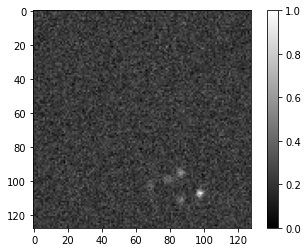

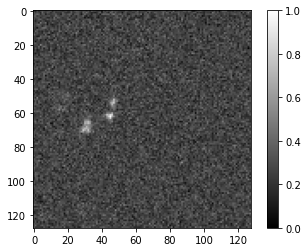

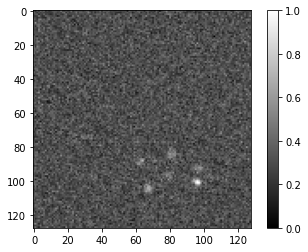

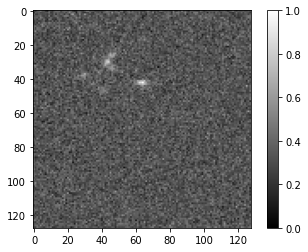

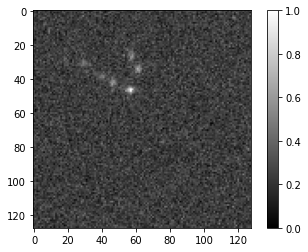

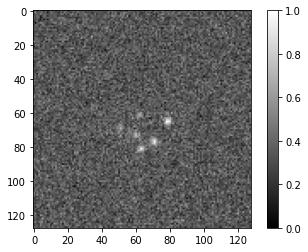

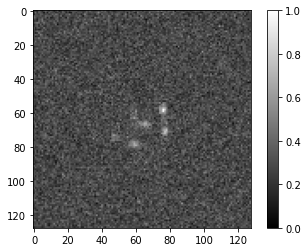

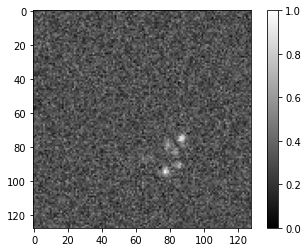

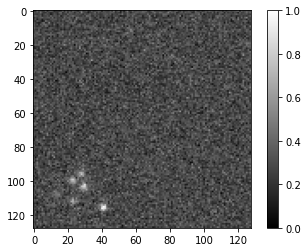

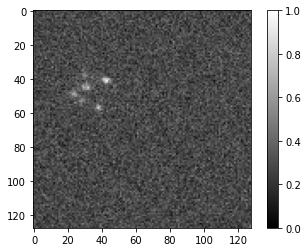

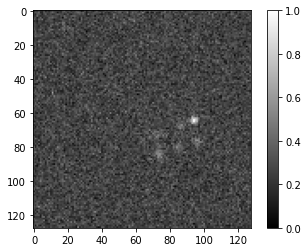

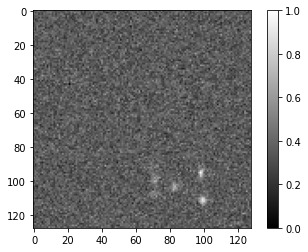

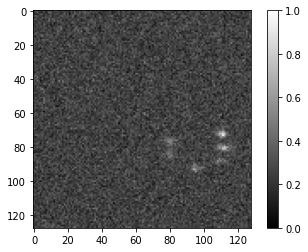

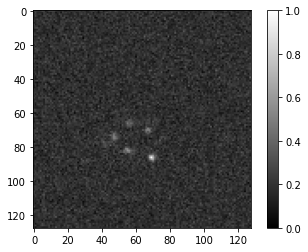

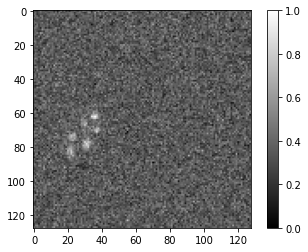

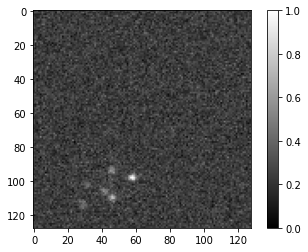

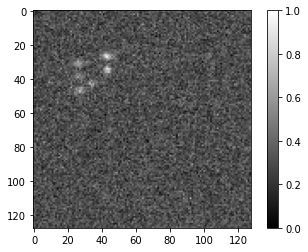

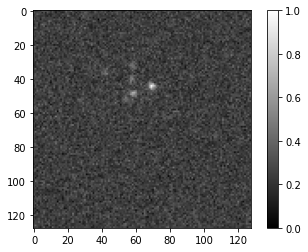

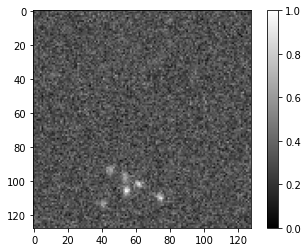

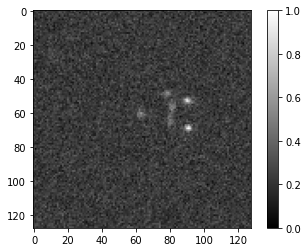

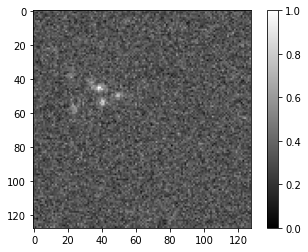

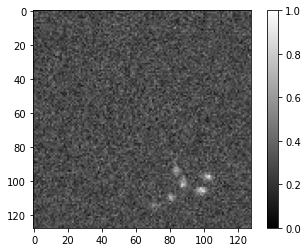

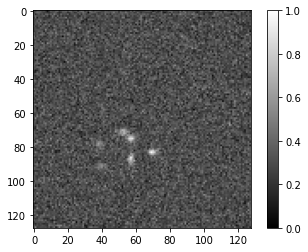

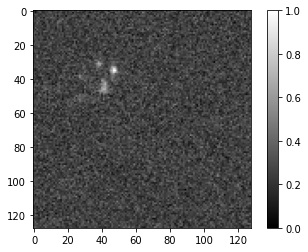

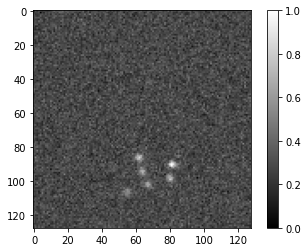

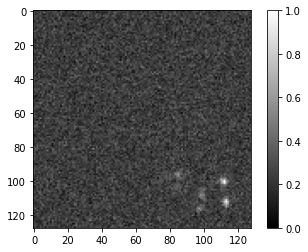

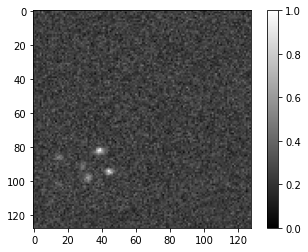

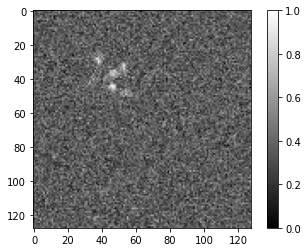

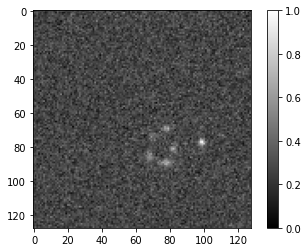

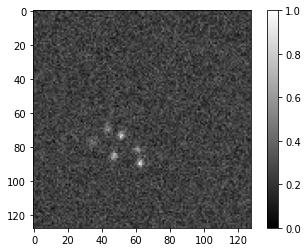

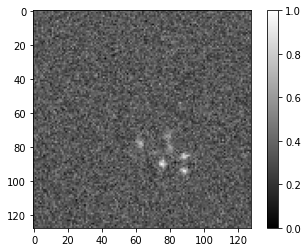

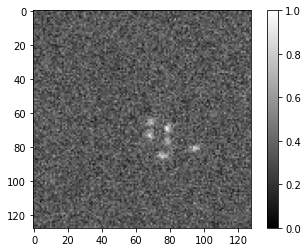

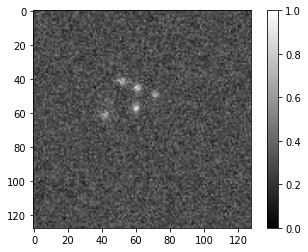

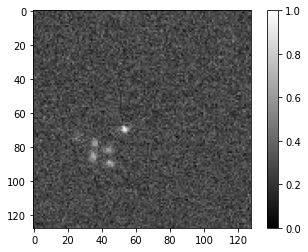

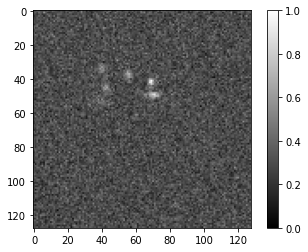

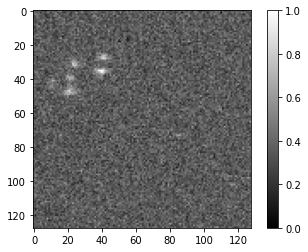

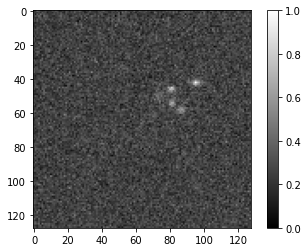

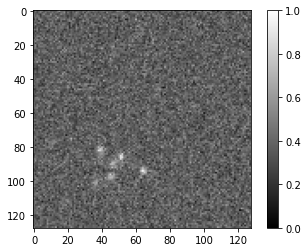

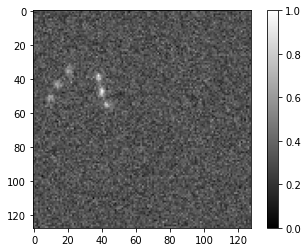

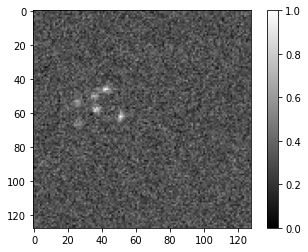

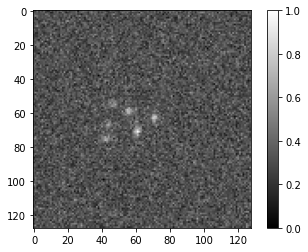

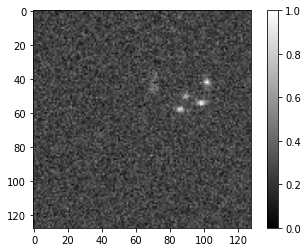

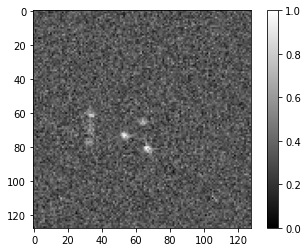

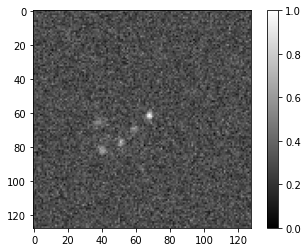

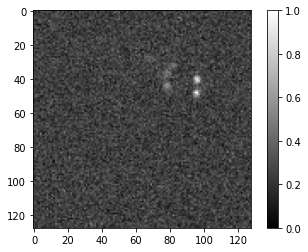

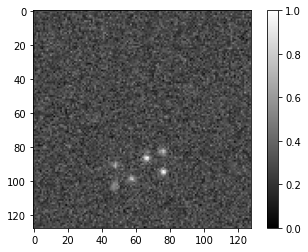

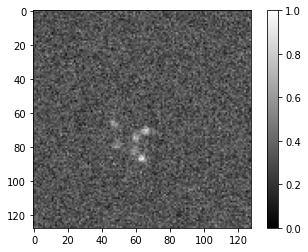

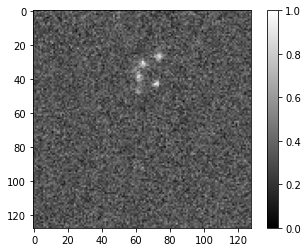

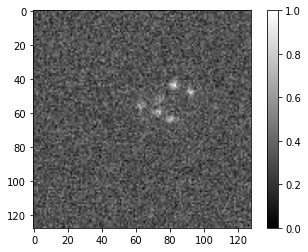

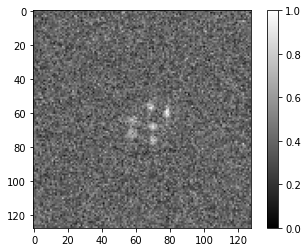

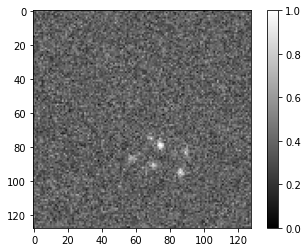

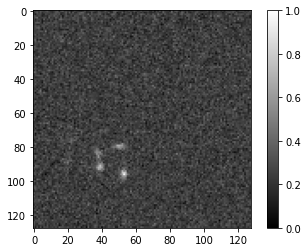

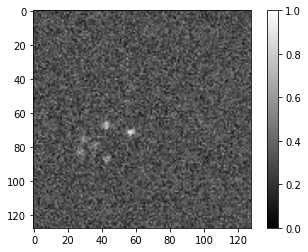

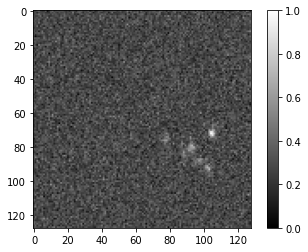

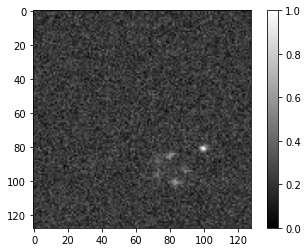

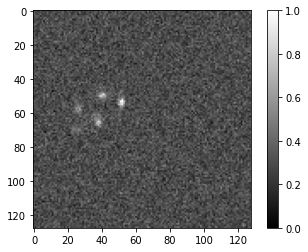

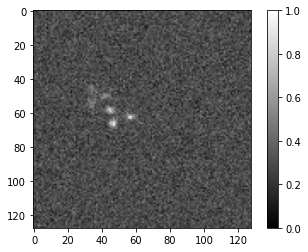

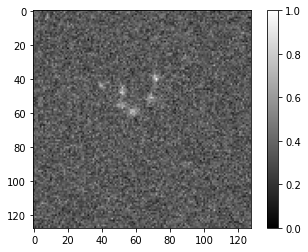

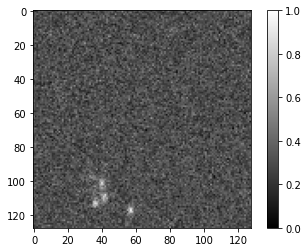

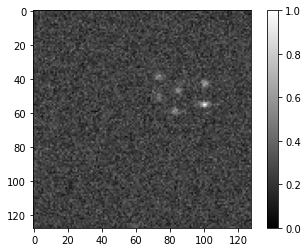

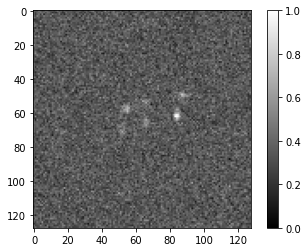

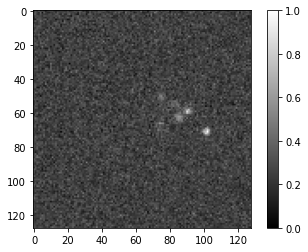

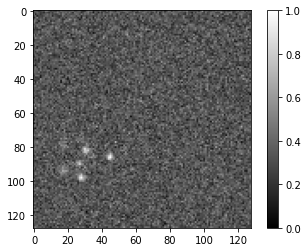

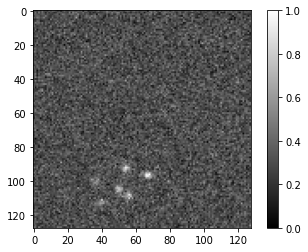

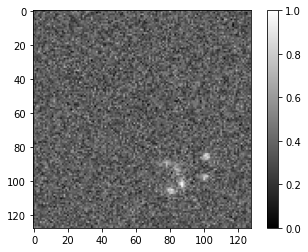

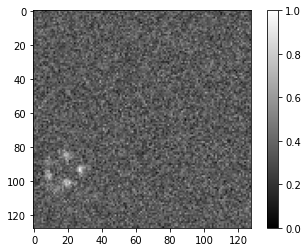

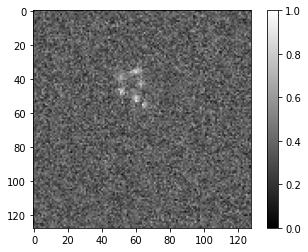

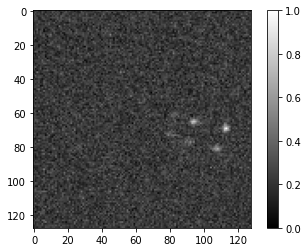

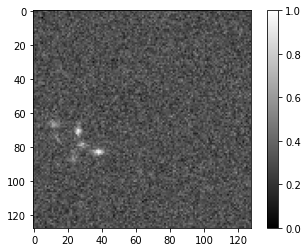

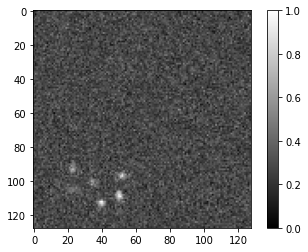

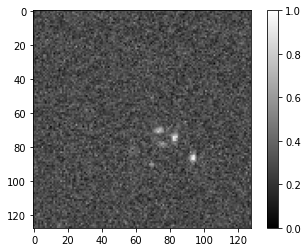

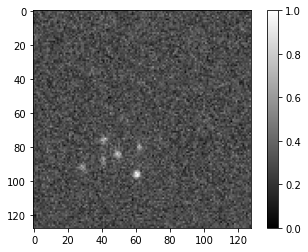

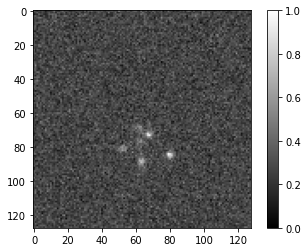

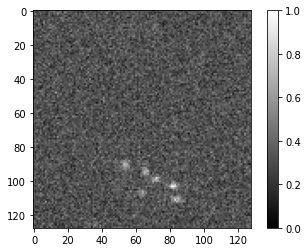

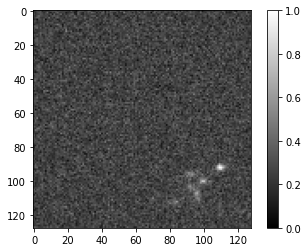

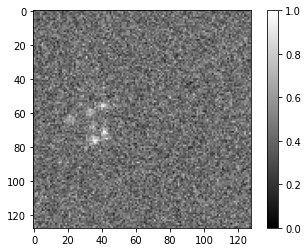

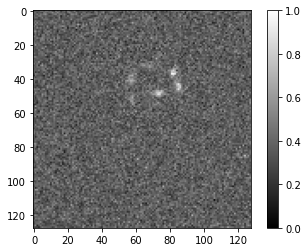

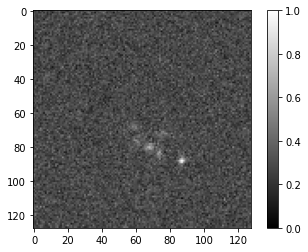

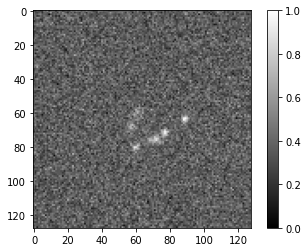

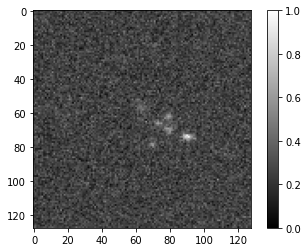

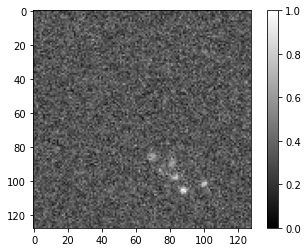

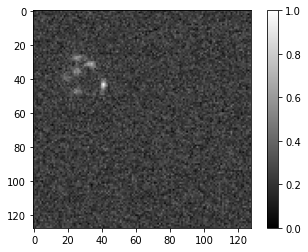

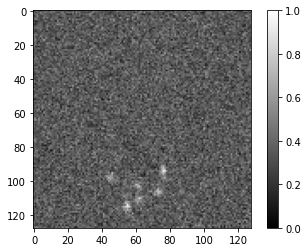

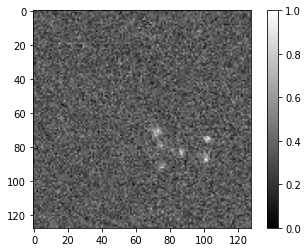

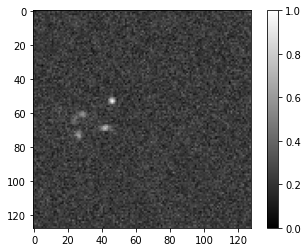

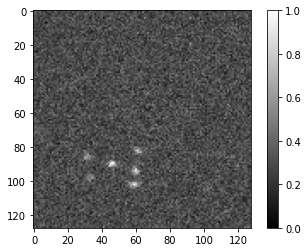

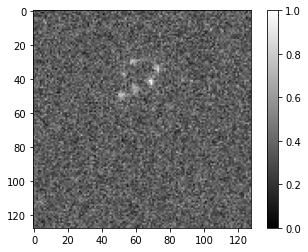

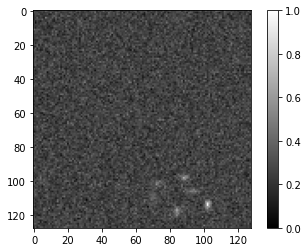

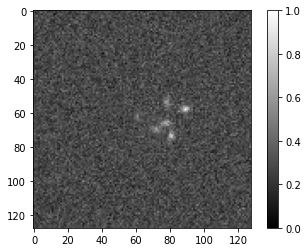

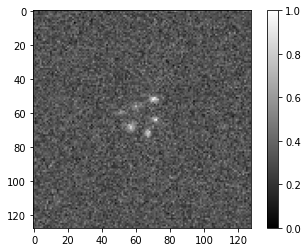

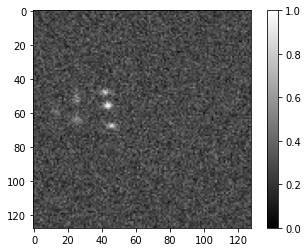

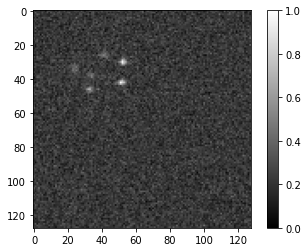

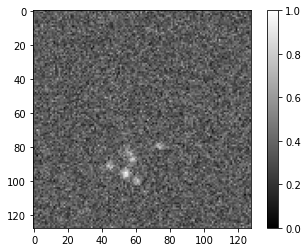

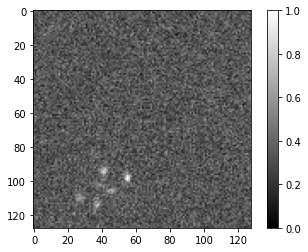

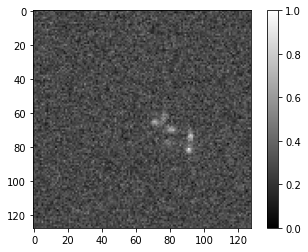

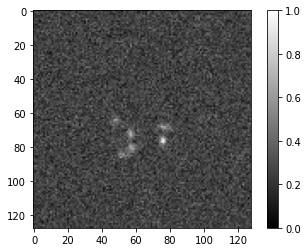

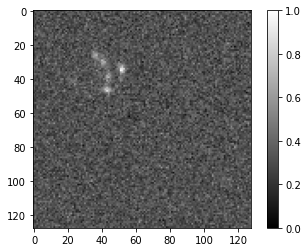

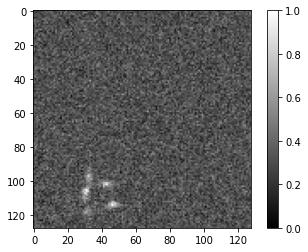

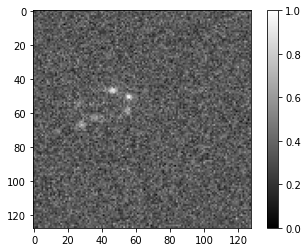

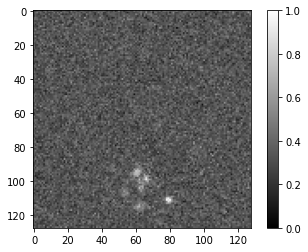

In [3]:
for indx in range(100): 
    plt.imshow(data_x[indx][0,:,:], cmap="gray")
    plt.colorbar()
    plt.show()

In [4]:
data_x = np.array(data_x)
data_y = np.array(data_y)
data_seq = np.array(data_seq)
data_pos = np.array(data_pos)
np.save("data_x.npy", data_x)
np.save("data_y.npy", data_y)
np.save("data_seq.npy", data_seq)
np.save("data_pos.npy", data_pos)